In [ ]:
pip install numpy scipy

In [ ]:
#importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the  data set**

In [ ]:
import os
import cv2

# Function to load images from a directory
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # assuming images are jpg or png
            img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
            images.append(img)
    return images

# Load the dataset
def load_dataset(dataset_dir):
    dataset = {'image': {}, 'mask': {}}
    for class_name in ['mask', 'image']:
        class_path = os.path.join(dataset_dir, class_name)
        for subpart_name in os.listdir(class_path):
            subpart_path = os.path.join(class_path, subpart_name)
            if os.path.isdir(subpart_path):
                dataset[class_name][subpart_name] = load_images(subpart_path)
    return dataset

# Directory path for the dataset
dataset_dir = '/content/drive/MyDrive/Brain Tumor/extracted dataset'

# Load the dataset
dataset = load_dataset(dataset_dir)


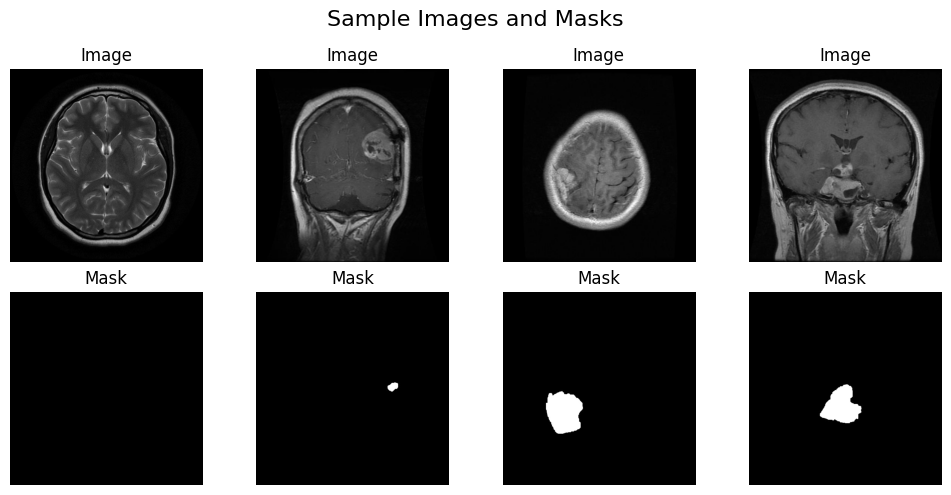

In [ ]:
import matplotlib.pyplot as plt

# Choose a sample from each class and subpart to display
sample_images = []
sample_masks = []

for subpart_name in dataset['image'].keys():
    sample_image = dataset['image'][subpart_name][3]  # Choose the third image from each subpart
    sample_mask = dataset['mask'][subpart_name][3]   # Choose the third mask from each subpart
    sample_images.append(sample_image)
    sample_masks.append(sample_mask)

# Display the sample images and masks
def display_images_and_masks(images, masks):
    fig, axes = plt.subplots(2, len(images), figsize=(10, 5))
    fig.suptitle('Sample Images and Masks', fontsize=16)

    for i, (image, mask) in enumerate(zip(images, masks)):
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title('Image')
        axes[0, i].axis('off')

        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_images_and_masks(sample_images, sample_masks)


**Bitwise AND**

In [ ]:
!pip install open cv

ERROR: Could not find a version that satisfies the requirement open (from versions: none)
ERROR: No matching distribution found for open


In [ ]:
import os
import cv2
import numpy as np

# Function to resize images to a specified shape
def resize_images(images, target_shape):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, target_shape)
        resized_images.append(resized_image)
    return resized_images

# Function to perform bitwise AND operation between image and mask
def segment_images(images, masks):
    segmented_images = []
    for image, mask in zip(images, masks):
        # Resize the mask to match the size of the image
        resized_mask = cv2.resize(mask, image.shape[:2][::-1])
        # Perform bitwise AND operation
        segmented_image = cv2.bitwise_and(image, resized_mask)
        segmented_images.append(segmented_image)
    return segmented_images

# Perform bitwise AND operation on all images and masks
segmented_images = {}
for subpart_name in dataset['image'].keys():
    images = dataset['image'][subpart_name]
    masks = dataset['mask'][subpart_name]

    try:
        # Optionally, resize images to a common shape if needed
        # images = resize_images(images, (desired_height, desired_width))

        segmented_images[subpart_name] = segment_images(images, masks)
    except ValueError as e:
        print(f"Error processing subpart {subpart_name}: {e}")

# Save segmented images to the drive
output_dir = '/content/drive/MyDrive/Brain Tumor/segmented image after bitwise AND'
os.makedirs(output_dir, exist_ok=True)

for subpart_name, images in segmented_images.items():
    subpart_dir = os.path.join(output_dir, subpart_name)
    os.makedirs(subpart_dir, exist_ok=True)
    for i, image in enumerate(images):
        filename = f"segmented_image_{i}.jpg"
        cv2.imwrite(os.path.join(subpart_dir, filename), image)

print("Segmented images saved successfully.")


Segmented images saved successfully.


**Display Segmented image**

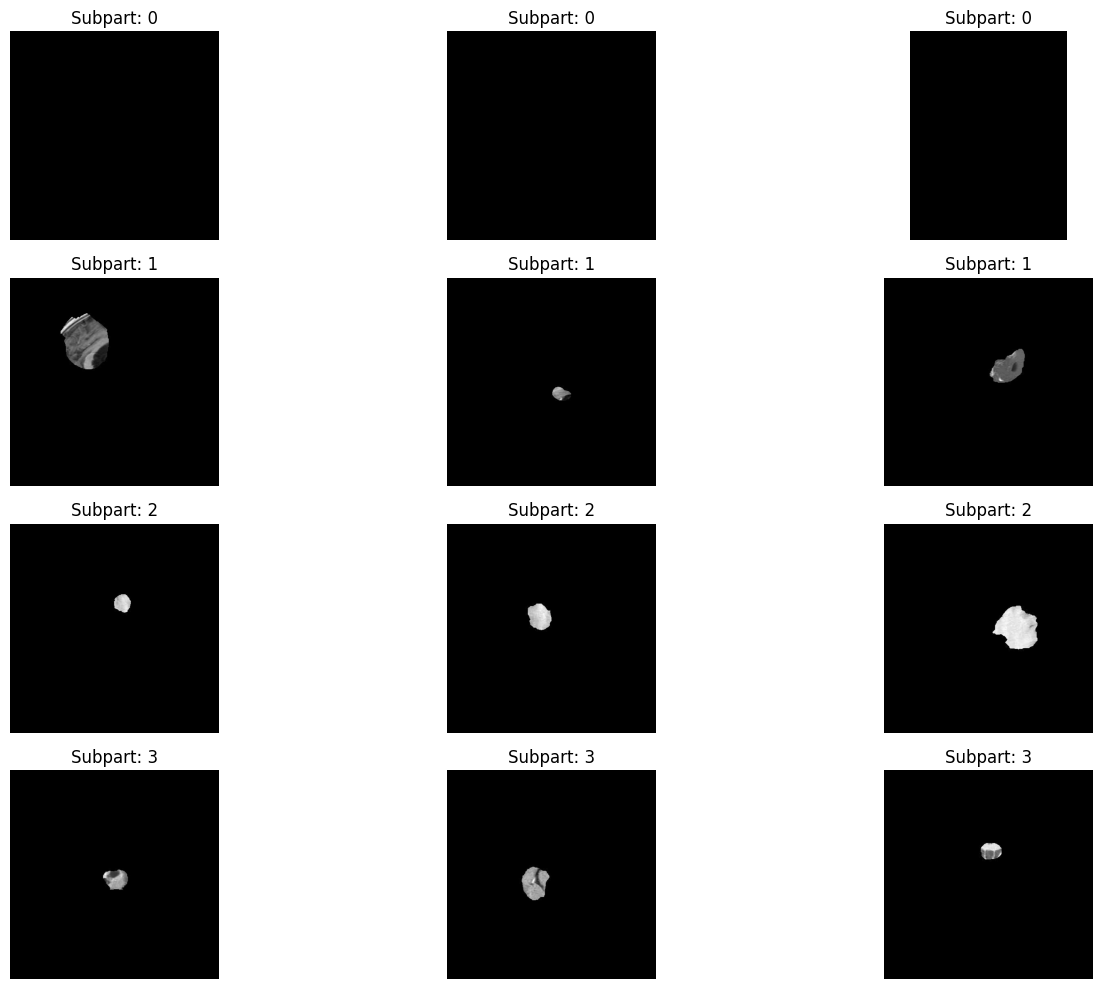

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Function to load segmented images from a directory
def load_segmented_images(directory):
    segmented_images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # assuming images are jpg or png
            img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
            segmented_images.append(img)
    return segmented_images

# Load segmented images from each subpart
segmented_images = {}
segmented_images_dir = '/content/drive/MyDrive/Brain Tumor/segmented image after bitwise AND'  # Update with your directory path

for subpart_name in ['0', '1', '2', '3']:
    subpart_path = os.path.join(segmented_images_dir, subpart_name)
    segmented_images[subpart_name] = load_segmented_images(subpart_path)

# Display some segmented images from each subpart
num_samples = 3  # Number of samples to display from each subpart
fig, axes = plt.subplots(len(segmented_images), num_samples, figsize=(15, 10))

for i, (subpart_name, images) in enumerate(segmented_images.items()):
    for j in range(num_samples):
        ax = axes[i][j]
        ax.imshow(images[j], cmap='gray')
        ax.set_title(f'Subpart: {subpart_name}')
        ax.axis('off')

plt.tight_layout()
plt.show()


**Compute the depth map for each segmented image**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/245M [00:00<?, ?B/s]

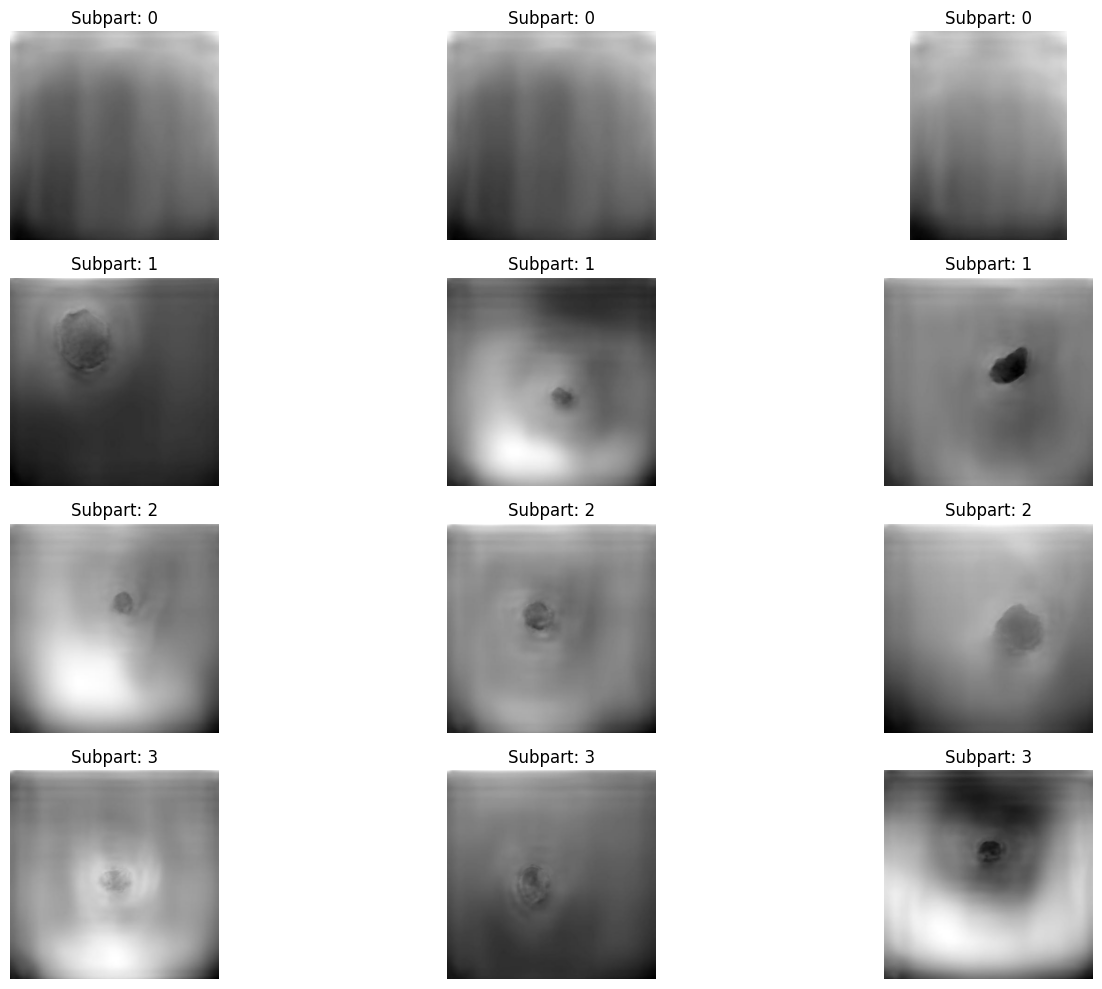

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import os

# Function to compute depth map for a given image
def compute_depth_map(image_path):
    feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
    model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

    # Load and resize the input image
    try:
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        new_height = 480 if image.height > 480 else image.height
        new_height -= (new_height % 32)
        new_width = int(new_height * image.width / image.height)
        diff = new_width % 32
        new_width = new_width - diff if diff < 16 else new_width + 32 - diff
        new_size = (new_width, new_height)
        image = image.resize(new_size)
    except Exception as e:
        print(f"Error loading or resizing image: {e}")
        return None

    # Prepare image for the model
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Get the prediction from the model
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # Remove borders
    pad = 16
    output = predicted_depth.squeeze().cpu().numpy() * 1000.0
    output = output[pad:-pad, pad:-pad]

    return output

# Directory path for segmented images
segmented_images_dir = "/content/drive/MyDrive/Brain Tumor/segmented image after bitwise AND"
# Directory path for saving depth map images
depth_map_output_dir = '/content/drive/MyDrive/Brain Tumor/depth map '
os.makedirs(depth_map_output_dir, exist_ok=True)

# Compute depth map for each segmented image and save
for subpart_name in os.listdir(segmented_images_dir):
    subpart_path = os.path.join(segmented_images_dir, subpart_name)
    output_subpart_path = os.path.join(depth_map_output_dir, subpart_name)
    os.makedirs(output_subpart_path, exist_ok=True)

    for filename in os.listdir(subpart_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(subpart_path, filename)
            depth_map = compute_depth_map(image_path)

            if depth_map is not None:
                # Save depth map
                depth_map_filename = f"{os.path.splitext(filename)[0]}_depth.jpg"
                depth_map_path = os.path.join(output_subpart_path, depth_map_filename)
                plt.imsave(depth_map_path, depth_map, cmap='gray')

# Display some depth maps from each subpart
num_samples = 3  # Number of samples to display from each subpart
fig, axes = plt.subplots(len(os.listdir(segmented_images_dir)), num_samples, figsize=(15, 10))

for i, subpart_name in enumerate(os.listdir(segmented_images_dir)):
    subpart_depth_map_dir = os.path.join(depth_map_output_dir, subpart_name)
    depth_map_images = [os.path.join(subpart_depth_map_dir, f) for f in os.listdir(subpart_depth_map_dir)]

    for j in range(num_samples):
        ax = axes[i][j]
        depth_map_image = Image.open(depth_map_images[j])
        ax.imshow(depth_map_image, cmap='gray')
        ax.set_title(f'Subpart: {subpart_name}')
        ax.axis('off')

plt.tight_layout()
plt.show()


**Mean Depth Map**

In [ ]:
import numpy as np
import os
import cv2

# Function to compute the mean depth map
def compute_mean_depth_map(depth_maps):
    mean_depth_maps = {}
    # Iterate through all depth maps
    for subpart_name, depth_map_list in depth_maps.items():
        # Find the maximum dimensions among all depth maps
        max_height = max(depth_map.shape[0] for depth_map in depth_map_list)
        max_width = max(depth_map.shape[1] for depth_map in depth_map_list)

        # Resize all depth maps to the maximum dimensions
        resized_depth_maps = []
        for depth_map in depth_map_list:
            resized_depth_map = cv2.resize(depth_map, (max_width, max_height))
            resized_depth_maps.append(resized_depth_map)

        # Accumulate depth values and compute the mean depth map
        total_depth_map = np.zeros_like(resized_depth_maps[0], dtype=np.float32)
        count = len(resized_depth_maps)

        for depth_map in resized_depth_maps:
            total_depth_map += depth_map.astype(np.float32)

        if count > 0:
            mean_depth_map = total_depth_map / count
            mean_depth_maps[subpart_name] = mean_depth_map.astype(np.uint8)
        else:
            mean_depth_maps[subpart_name] = None

    return mean_depth_maps

# Directory path for depth map images
depth_map_images_dir = '/content/drive/MyDrive/Brain Tumor/depth map '

# Compute mean depth map for each subpart
depth_maps = {}
for subpart_name in os.listdir(depth_map_images_dir):
    subpart_path = os.path.join(depth_map_images_dir, subpart_name)
    depth_map_list = []

    for filename in os.listdir(subpart_path):
        if filename.endswith('_depth.jpg'):
            depth_map_path = os.path.join(subpart_path, filename)
            depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)
            depth_map_list.append(depth_map)

    depth_maps[subpart_name] = depth_map_list

# Compute the mean depth map for each subpart
mean_depth_maps = compute_mean_depth_map(depth_maps)

# Directory path for saving mean depth maps
mean_depth_maps_output_dir = '/content/drive/MyDrive/Brain Tumor/mean depth map'
os.makedirs(mean_depth_maps_output_dir, exist_ok=True)

# Save mean depth maps for each subpart
for subpart_name, mean_depth_map in mean_depth_maps.items():
    if mean_depth_map is not None:
        subpart_output_dir = os.path.join(mean_depth_maps_output_dir, subpart_name)
        os.makedirs(subpart_output_dir, exist_ok=True)

        mean_depth_map_filename = f"mean_depth_map_{subpart_name}.jpg"
        mean_depth_map_path = os.path.join(subpart_output_dir, mean_depth_map_filename)
        cv2.imwrite(mean_depth_map_path, mean_depth_map)

print("Mean depth maps saved successfully.")


Mean depth maps saved successfully.


**Display Mean Depth Map**

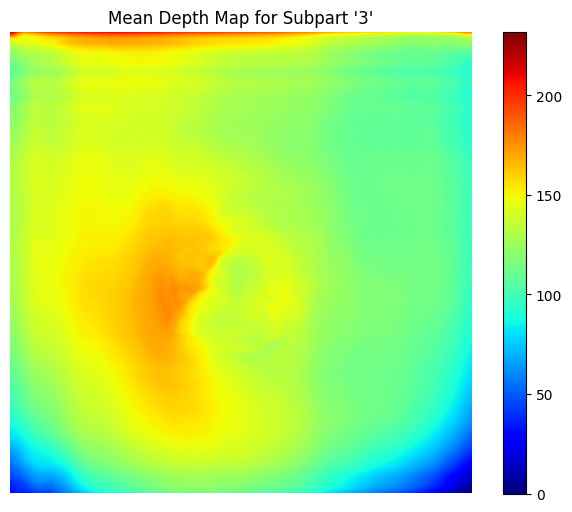

In [ ]:
# Function to display a specific mean depth map
def display_mean_depth_map(mean_depth_maps, subpart_name):
    if subpart_name in mean_depth_maps:
        mean_depth_map = mean_depth_maps[subpart_name]
        if mean_depth_map is not None:
            plt.figure(figsize=(8, 6))
            plt.imshow(mean_depth_map, cmap='jet')
            plt.title(f"Mean Depth Map for Subpart '{subpart_name}'")
            plt.colorbar()
            plt.axis('off')
            plt.show()
        else:
            print(f"No mean depth map found for subpart '{subpart_name}'.")
    else:
        print(f"No mean depth map found for subpart '{subpart_name}'.")

# Example usage: Specify the subpart name
subpart_name = '3'  # Change this to the desired subpart name
display_mean_depth_map(mean_depth_maps, subpart_name)


**3D Mesh Generation**

In [ ]:
!pip install trimesh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.8/693.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import trimesh
from google.colab import files

def generate_mesh(mean_depth_map, mesh_height, subpart_name):
    height, width = mean_depth_map.shape

    # Generate X, Y coordinates
    X, Y = np.meshgrid(np.arange(width), np.arange(height))

    # Scale depth values to create Z coordinates
    Z = mean_depth_map * mesh_height

    # Create vertices
    vertices = np.column_stack([X.flatten(), Y.flatten(), Z.flatten()])

    # Create faces
    faces = []
    for i in range(height - 1):
        for j in range(width - 1):
            v1 = i * width + j
            v2 = v1 + 1
            v3 = v1 + width
            v4 = v3 + 1
            faces.append([v1, v2, v4])
            faces.append([v1, v4, v3])
    faces = np.array(faces)

    # Create mesh
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    return mesh

# Directory path for mean depth maps and output folder for 3D meshes
mean_depth_maps_dir = '/content/drive/MyDrive/Brain Tumor/mean depth map'
output_mesh_folder = '/content/drive/MyDrive/Brain Tumor/3D mesh'
os.makedirs(output_mesh_folder, exist_ok=True)

# Mesh height (adjust as needed)
mesh_height = 1

# Generate and download 3D mesh in .ply format for each mean depth map
for subpart_name in os.listdir(mean_depth_maps_dir):
    subpart_path = os.path.join(mean_depth_maps_dir, subpart_name)

    for filename in os.listdir(subpart_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            depth_map_path = os.path.join(subpart_path, filename)
            mean_depth_map = plt.imread(depth_map_path)

            # Convert to grayscale if necessary
            if mean_depth_map.ndim == 3:
                mean_depth_map = np.mean(mean_depth_map, axis=2)

            # Generate mesh
            mesh = generate_mesh(mean_depth_map, mesh_height, subpart_name)

            # Save mesh as .ply file
            output_mesh_path = os.path.join(output_mesh_folder, f'{subpart_name}_mesh.ply')
            mesh.export(output_mesh_path)

            # Download mesh
            files.download(output_mesh_path)

print('All 3D meshes generated and downloaded successfully.')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All 3D meshes generated and downloaded successfully.


**Display 3D mesh**

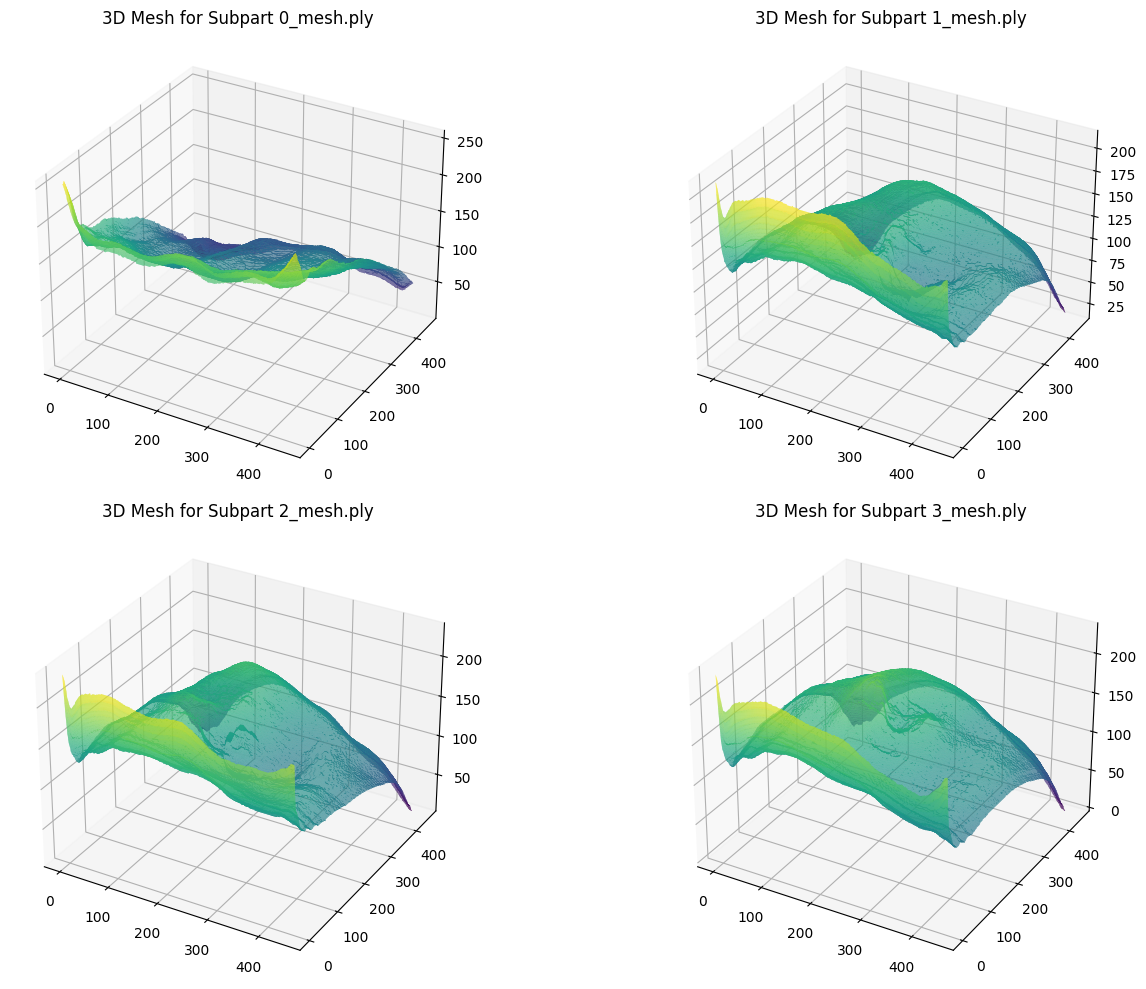

In [ ]:
import os
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Directory path for saved 3D mesh files
mesh_folder = '/content/drive/MyDrive/Brain Tumor/3D mesh'

# Display all four 3D meshes with their respective subpart names
fig = plt.figure(figsize=(15, 10))
for i, subpart_name in enumerate(os.listdir(mesh_folder), 1):
    mesh_path = os.path.join(mesh_folder, subpart_name)
    mesh = trimesh.load_mesh(mesh_path)

    # Plot 3D mesh
    ax = fig.add_subplot(2, 2, i, projection='3d')
    ax.set_title(f'3D Mesh for Subpart {subpart_name}')
    ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], triangles=mesh.faces, cmap='viridis')

plt.tight_layout()
plt.show()
